# Final Project

1.0
[[0. 0. 0. 0.]
 [0. 1. 2. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]]


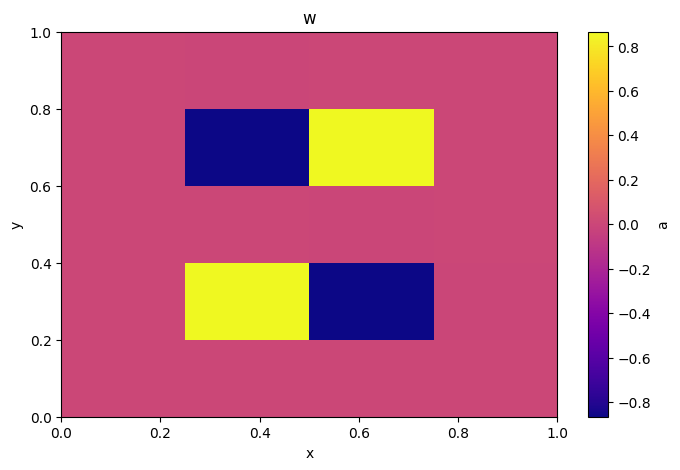

In [77]:
import numpy as np
from src.analysis.plots import color_plot

Xs = np.linspace(0, 1, 5)
Ys = np.linspace(0, 1, 4)
Ts = np.linspace(0, 2, 8)

X, T, Y = np.meshgrid(Xs, Ts, Ys)
Us = np.ones(X.shape)
print(Us.max())

Us[:, 0, :] = 0     # top
Us[:, -1, :] = 0    # bottom
Us[:, :, 0] = 0     # left
Us[:, :, -1] = 0    # right

Us[0, 1, 2] = 2
print(Us[0,:,:])

# print(X[:,:,0])
# print(Y[0:,:,])
# print(X[0, :, :])

def test_initial(x, y):
    return np.sin(2 * np.pi * x) * np.sin(2 * np.pi * y)

test = test_initial(X[0, :, :], Y[0,:,:])
color_plot(test, Xs, Ys, 'w', 'a', 'x', 'y')

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from src.analysis.plots import color_plot, line_plot
from src.numerical_methods.ftcs import ftcs_diffusion_1d

# plt.style.use(['science', 'notebook'])

zero_func = lambda x, t=0, k=0: 0
pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp
e = np.e

initial_condition = lambda x: sin(pi * x)

ft_Us, ft_Xs, ft_Ts = ftcs_diffusion_1d(
    k=1,
    x1=0,
    x2=1,
    T=0.3,
    initial_condition=initial_condition,
    dx=1e-2,
    left_bc=lambda t: 1,
    right_bc=lambda t: 1
)

(100,)


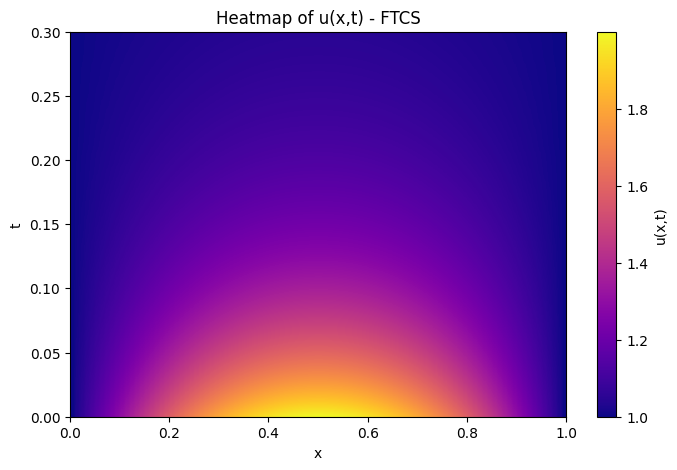

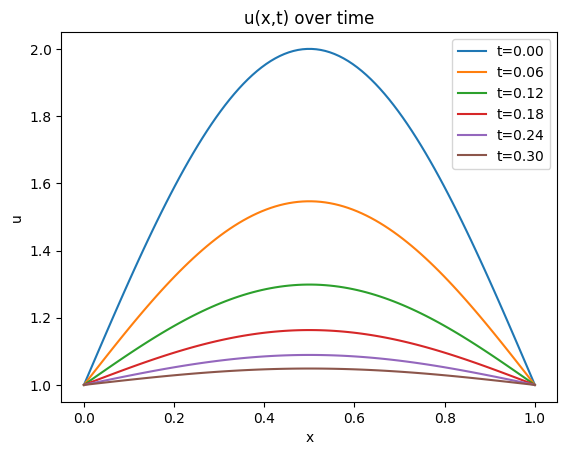

In [11]:
color_plot(ft_Us, ft_Xs, ft_Ts, title="Heatmap of u(x,t) - FTCS", bar_label="u(x,t)", xlabel="x", ylabel="t")
line_plot(ft_Us, ft_Xs, ft_Ts, 6, title="u(x,t) over time", xlabel="x", ylabel="u")

# Now for an unstable choice of dt and dx

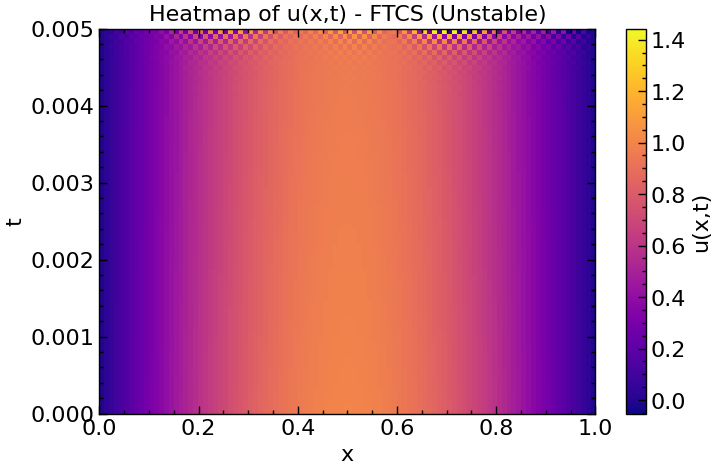

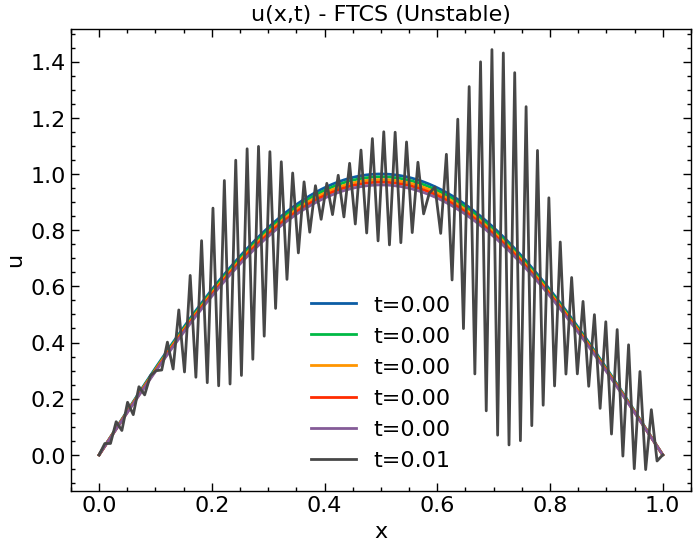

In [41]:
unstable_ft_Us, unstable_ft_Xs, unstable_ft_Ts = ftcs_diffusion_1d(
    k=1,
    x1=0,
    x2=1,
    T=0.0050,
    initial_condition=initial_condition,
    dx=1e-2,
    left_bc=zero_func,
    right_bc=zero_func,
    unstable=True
)

color_plot(unstable_ft_Us, unstable_ft_Xs, unstable_ft_Ts, title="Heatmap of u(x,t) - FTCS (Unstable)", bar_label="u(x,t)", xlabel="x", ylabel="t")
line_plot(unstable_ft_Us, unstable_ft_Xs, unstable_ft_Ts, 6, title="u(x,t) - FTCS (Unstable)", xlabel="x", ylabel="u")

# Crank-Nicolson Method

In [7]:
def create_tridiagonal_matrix(main_diag, upper_diag, lower_diag):
    n = len(main_diag)
    if len(upper_diag) != n - 1 or len(lower_diag) != n - 1:
        raise ValueError('Dimension Mismatch: Try again')

    matrix = np.diag(main_diag)
    matrix += np.diag(upper_diag, k=1)
    matrix += np.diag(lower_diag, k=-1)
    return matrix

def generate_CN_matrix(main, uplo, corner, n):
    main_diag = np.ones(n) * main
    main_diag[0] = main_diag[-1] = corner

    upper_diag = np.ones(n - 1) * uplo
    lower_diag = np.ones(n - 1) * uplo
    upper_diag[0] = 0
    lower_diag[-1] = 0

    return create_tridiagonal_matrix(main_diag, upper_diag, lower_diag)

def crank_nicolson_1d(k, L1, L2, T, Nx, Nt, initial_condition, left_bc = zero_func, right_bc = zero_func, source = zero_func):
    """
     k:             diffusivity constant
     L1:            left endpoint of spatial interval
     L2:            right endpoint of spatial interval
     T:             final time
     Nx:            number of x points
     Nt:            number of t points
     left_BC:       function of t ONLY
     right_BC:      ^^^^^^^^
     initial_con:   function of x ONLY
     source:        function of x and t
    """
    dx = (L2 - L1) / (Nx - 1)       # maybe change to Nx - 1
    dt = T / (Nt - 1)               # ^^^^^

    Xs = np.linspace(L1, L2, Nx)
    Ts = np.linspace(0, T, Nt)

    alpha = k * dt / (dx ** 2)
    gamma = 2 * (1 + alpha)
    beta = 2 * (1 - alpha)

    A = generate_CN_matrix(gamma, -alpha, 1, Nx)
    B = generate_CN_matrix(beta, alpha, 0, Nx)

    curr_u = initial_condition(Xs)
    U = [curr_u]

    for t in Ts[:-1]: # t loop finds Us for t + 1

        # Apply source term
        curr_source = (source(Xs, t, k) + source(Xs, t + dt, k)) * dt

        # Apply average boundary conditions
        boundary = np.zeros(Nx)
        boundary[0] = (left_bc(t) + left_bc(t + dt)) / 2 #* alpha
        boundary[-1] = (right_bc(t) + right_bc(t + dt)) / 2 #* alpha


        RHS = (B @ curr_u) + curr_source + boundary
        curr_u = np.linalg.solve(A, RHS)
        U.append(curr_u)

    return np.array(U), Xs, Ts

NameError: name 'zero_func' is not defined

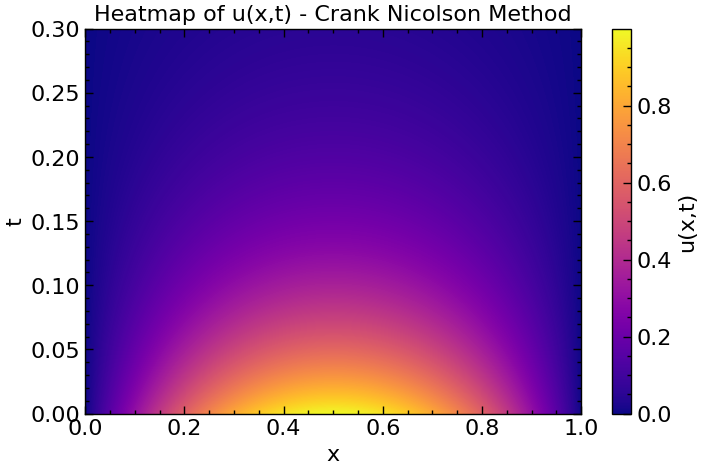

In [59]:
CN_Us, CN_Xs, CN_Ts = crank_nicolson_1d(
    k = 1,
    L1 = 0,
    L2 = 1,
    T = 0.3,
    Nx = 1000,
    Nt = 500,
    initial_condition = lambda x: sin(pi * x),
    left_bc = zero_func,
    right_bc = zero_func,
    source = zero_func
)
print(Us[0].shape)

color_plot(CN_Us, CN_Xs, CN_Ts, title="Heatmap of u(x,t) - Crank Nicolson Method", bar_label='u(x,t)', xlabel="x", ylabel="t")

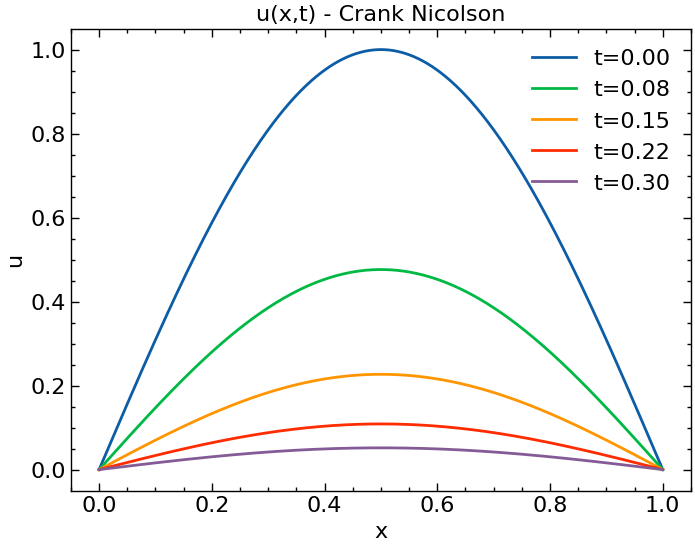

In [61]:
line_plot(CN_Us, CN_Xs, CN_Ts, 5, 'u(x,t) - Crank Nicolson', 'x', 'u')

# Test Function

In [20]:
"""
A sample true solution to test error:
u(x,t) = sin(pi * x) * exp(-pi^2 * k * t)  on [0,1]
u(x,0) = sin(pi * x)
u(0,t) = u(1,t) = 0
"""

def test_solution(x, t, k):
    return sin(pi * x) * exp(-(pi ** 2) * k * t)

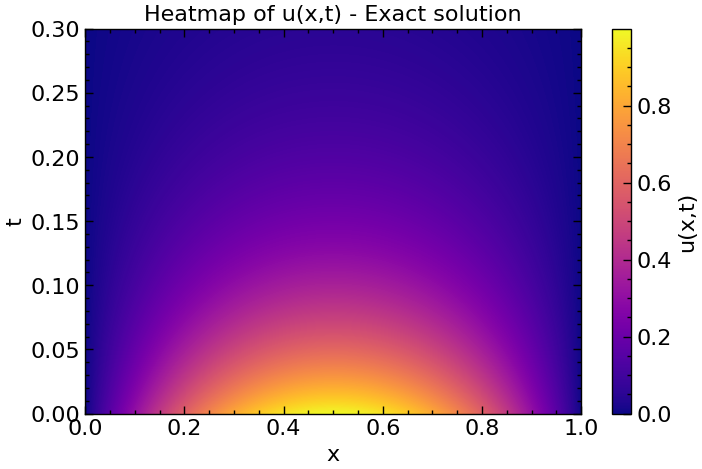

In [63]:
solution_Xs = np.linspace(0, 1, 1000)
solution_Ts = CN_Ts
sol_X, sol_T = np.meshgrid(solution_Xs, solution_Ts)
sol_U = test_solution(sol_X, sol_T, 1)

color_plot(sol_U, solution_Xs, solution_Ts, title='Heatmap of u(x,t) - Exact solution', bar_label='u(x,t)', xlabel='x', ylabel='t')

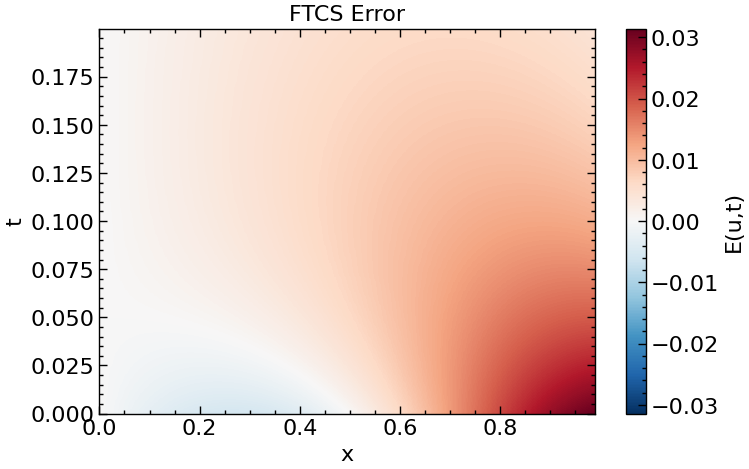

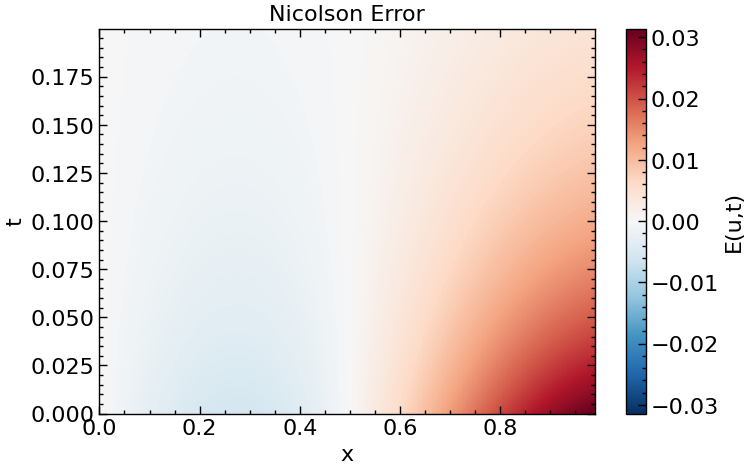

In [68]:
def plot_errors(k, L1, L2, T, dx, true_function, initial_condition, left_bc, right_bc):

    dt = (dx ** 2) / (k * 3)

    Nx = int((L2 - L1) / dx)
    Nt = int(T / dt)

    ftcs_Us, _, _ = ftcs_diffusion_1d(k, L1, L2, T, initial_condition, dx, left_bc, right_bc)
    nicolson_Us, _, _ = crank_nicolson_1d(k, L1, L2, T, Nx, Nt, initial_condition, left_bc, right_bc)

    Xs = np.arange(L1, L2, dx)
    Ts = np.arange(0, T, dt)
    X_grid, T_grid = np.meshgrid(Xs, Ts)

    true_Us = true_function(X_grid, T_grid, k)

    ftcs_errors = true_Us - ftcs_Us
    nicolson_errors = true_Us - nicolson_Us
    error_diff = nicolson_errors - ftcs_errors

    vmax = max(
        np.max(ftcs_errors),
        np.max(nicolson_errors)
    )
    vmin = -1 * vmax


    color_plot(ftcs_errors, Xs, Ts, title='FTCS Error', bar_label='E(u,t)', xlabel='x', ylabel='t', cmap='RdBu_r',vmin=vmin, vmax=vmax)
    color_plot(nicolson_errors, Xs, Ts, title='Nicolson Error', bar_label='E(u,t)', xlabel='x', ylabel='t', cmap='RdBu_r', vmin=vmin, vmax=vmax)

plot_errors(1, 0, 1, 0.2, 1e-2, test_solution, initial_condition, zero_func, zero_func)


# Now for another known equation, this time with a source
$$
    u_t = ku_{xx} + f(x,t), \quad x \in [L_1,L_2], t>0
$$
With known solution:
$$
    u(x,t) = e^{-t} \sin(\pi x), \quad x \in [0,1]
    $$
    $$
    u(x,0) = \sin(\pi x),\quad u(0,t)=u(1,t) = 0
    $$
    $$
    f(x,t)= e^{-t}\sin(\pi x)(k\pi^2-1)
$$

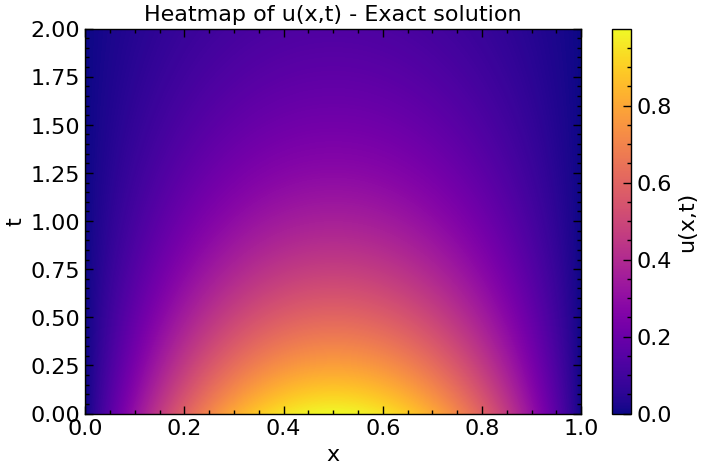

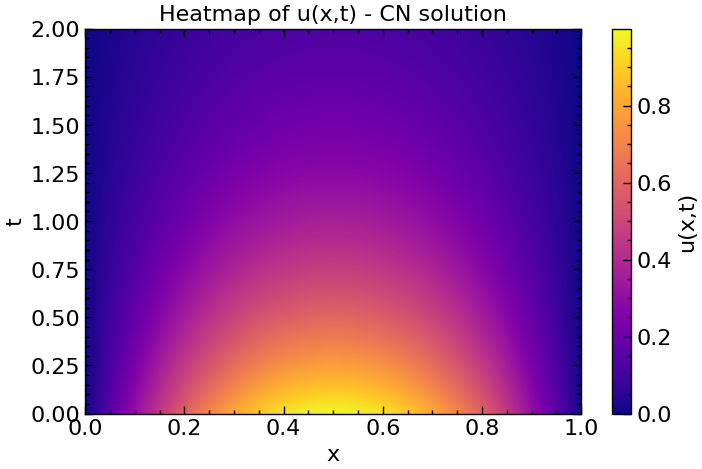

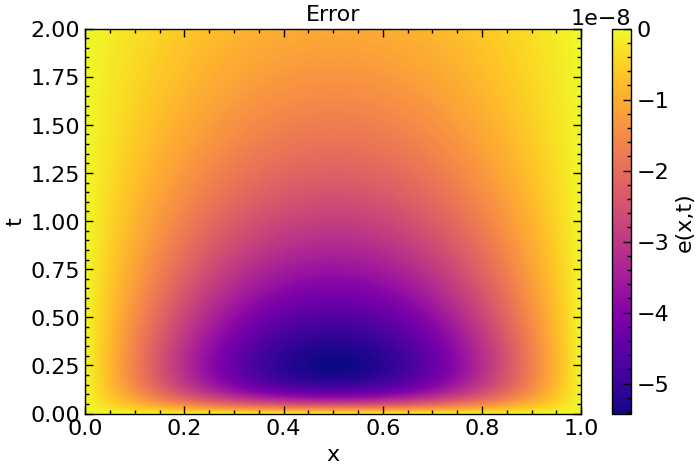

In [66]:
def test_function(x, t):
    return (e ** (-t)) * (sin(pi * x))

def test_source(x, t, k):
    return (e ** (-t)) * sin(pi * x) * (k * (pi ** 2) - 1)

CN_test_U, CN_test_X, CN_test_T = crank_nicolson_1d(
    k=1, L1=0, L2=1, T=2, Nx=1000, Nt=1000,
    initial_condition=initial_condition,
    left_bc=zero_func,
    right_bc=zero_func,
    source=test_source
)

test_Xs = np.linspace(0, 1, 1000)
test_Ts = CN_test_T
X, T = np.meshgrid(test_Xs, test_Ts)
test_U = test_function(X, T)

color_plot(test_U, test_Xs, test_Ts, title='Heatmap of u(x,t) - Exact solution', bar_label='u(x,t)', xlabel='x', ylabel='t')
color_plot(CN_test_U, CN_test_X, CN_test_T, title='Heatmap of u(x,t) - CN solution', bar_label='u(x,t)', xlabel='x', ylabel='t')
color_plot(test_U - CN_test_U, test_Xs, test_Ts, title='Error', bar_label='e(x,t)', xlabel='x', ylabel='t')

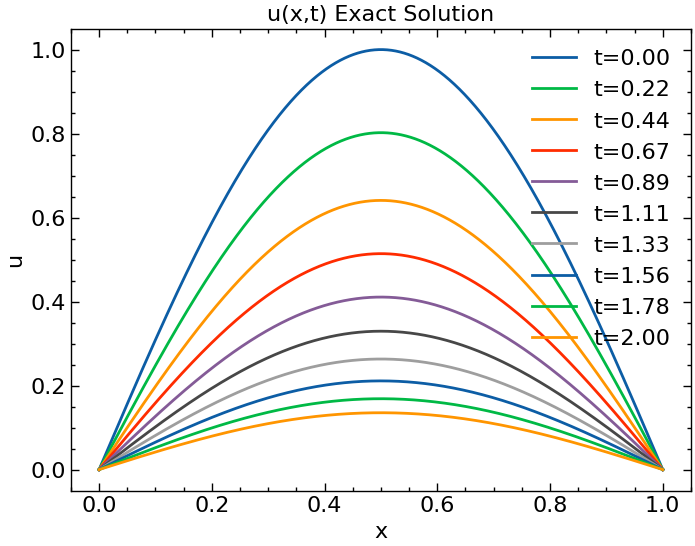

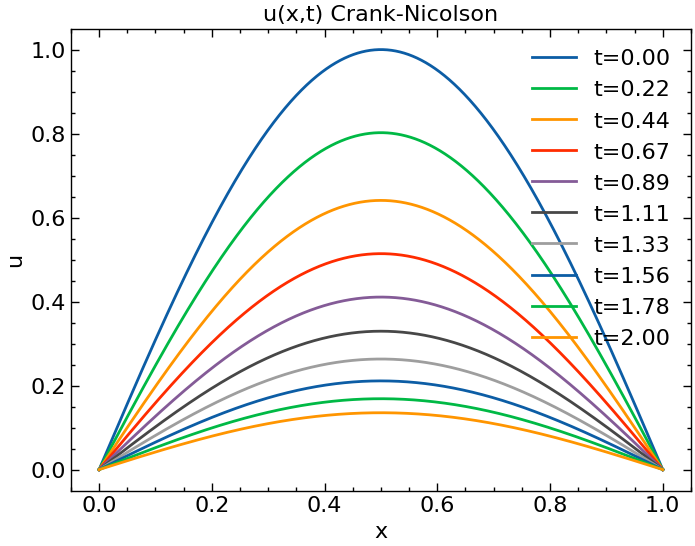

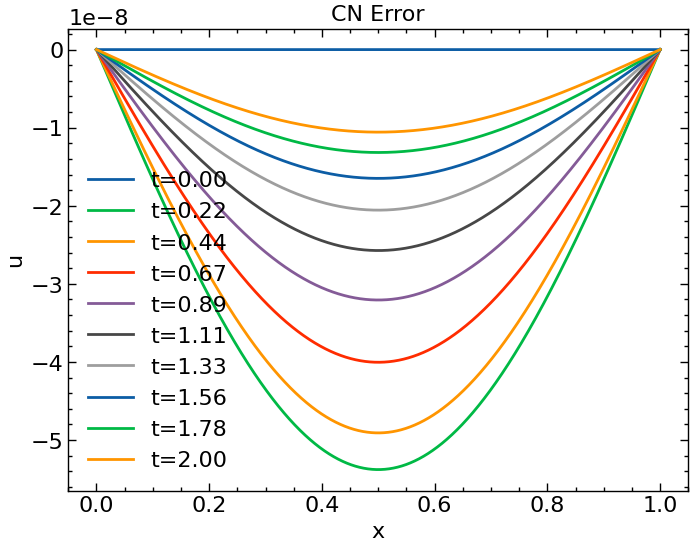

In [69]:
line_plot(test_U, test_Xs, test_Ts, 10, 'u(x,t) Exact Solution', 'x', 'u')
line_plot(CN_test_U, test_Xs, test_Ts, 10, 'u(x,t) Crank-Nicolson', 'x', 'u')
line_plot(test_U - CN_test_U, test_Xs, test_Ts, 10, 'CN Error', 'x', 'u')

# Now to test nonhomogeneous boundary conditions

In [78]:
BC_Us, BC_Xs, BC_Ts = crank_nicolson_1d(
    k=1,
    L1=0,
    L2=1,
    T=0.1,
    Nx=500,
    Nt=500,
    initial_condition = lambda x: cos(3 * pi * x),
    left_bc = lambda x, t=0, k=0: 1,
    right_bc = lambda x, t=0, k=0: -1,
)

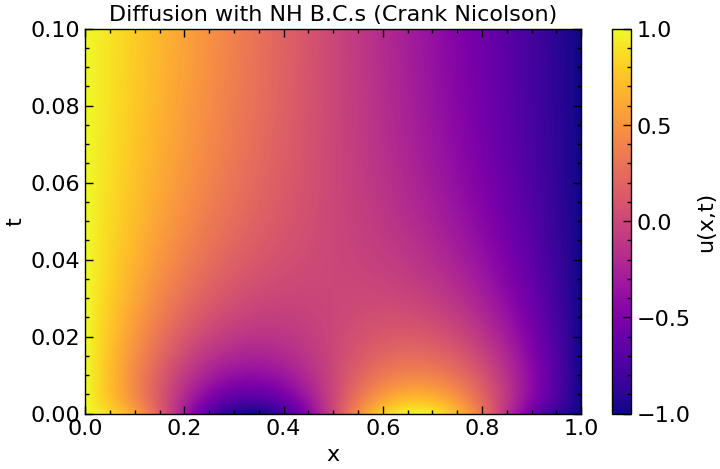

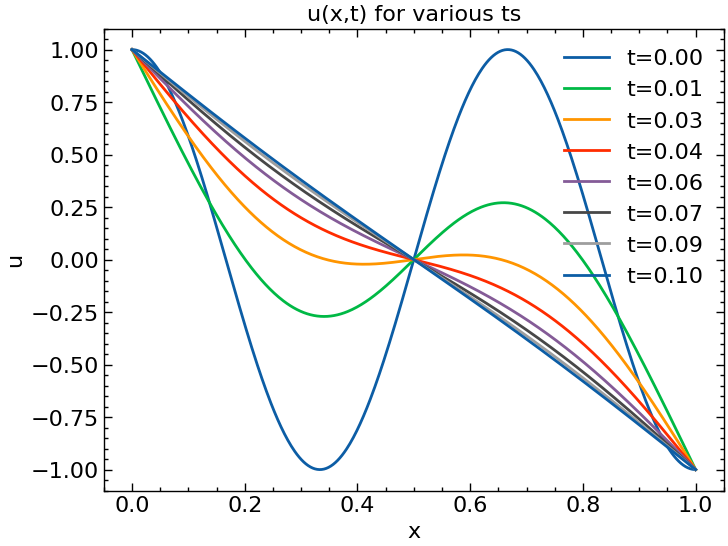

In [80]:
color_plot(BC_Us, BC_Xs, BC_Ts, 'Diffusion with NH B.C.s (Crank Nicolson)', bar_label='u(x,t)', xlabel='x', ylabel='t')
line_plot(BC_Us, BC_Xs, BC_Ts, 8, 'u(x,t) for various ts', xlabel='x', ylabel='u')